# Binary Planet Suppression: Filtering

In [1]:
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import pickle
import pandas as pd

# my preferred settings
mpl.rc('lines',linewidth = 1.5)
mpl.rc('font',size = 12)
mpl.rc('axes',labelsize = 16, linewidth=1.25)
mpl.rc('xtick',labelsize = 16)
mpl.rc('ytick',labelsize = 16)
# enable math fonts
mpl.rc('mathtext', default = 'regular')

from sbin.sbin import suppression_factor, suppression_simulation
from sbin import parameters

In [86]:
parameters.radius_limit = 4
max_radius_error = 0.15
parameters.radius_valley = 1.7

### Data from Sullivan, Gaia/Bedell, KOIs, KIC

In [65]:
# read in Kendall's catalog, xmatched to all the stuff from Kepler that I need
with open('kendall+kepler.pkl', 'rb') as file:
       db = pickle.load(file)

# read in my kois table
with open('kois+gaia.pkl', 'rb') as file:
        kois = pd.read_pickle(file)

# remove the studied binaries from the all_KOI catalog
kois_less = kois[ (~kois['kepoi_name'].isin(db['kepoi_name'])) & \
                 (kois['koi_disposition']=='CONFIRMED') & \
                 np.isfinite(kois['parallax']) & \
                 (kois['ruwe']<1.2) ]

print('KOIs, all', len(kois[ (~kois['kepoi_name'].isin(db['kepoi_name'])) & \
                 (kois['koi_disposition']=='CONFIRMED')]) )
print('KOIs, singles', len(kois_less))
print('Binaries, all planets', len(db))
print('Binaries, unique stars', len(db['KOI'].unique()))

KOIs, all 2504
KOIs, singles 2404
Binaries, all planets 404
Binaries, unique stars 286


### CKS Sample

In [66]:
tmp = Table.read('fulton2018.vot')
cks = tmp.to_pandas()
cks['kepoi_name'] = cks['KOI']
cks['KOI'] = cks['kepoi_name'].str.extract(r'K0*(\d+)\.\d+')[0].astype(int)


### Optional limit on periods

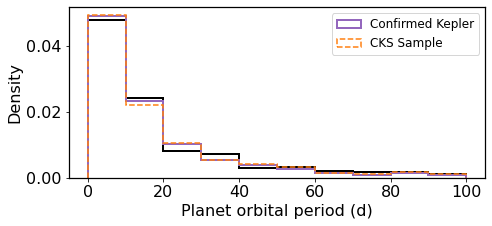

In [67]:
nbins = 10
histrange = (0,100)
fig, axes = plt.subplots(1, 1, figsize=(7,3.3), sharex=True, sharey=True)

plt.hist(db['koi_period'], 
             range=histrange, bins=nbins, density=True, 
             histtype='step', color='k', lw=2 )

# compared to the kois that are at least not definite binaries with good radii and per<100 days
plt.hist(kois_less['koi_period'], 
             range=histrange, bins=nbins, density=True, 
             histtype='step', lw=2, color='C4',
        label='Confirmed Kepler')

# compared to the cks
plt.hist(cks['Per'], 
             range=histrange, bins=nbins, density=True, 
             histtype='step',lw=1.5, linestyle='--', color='C1',
        label='CKS Sample')

plt.ylabel('Density')
plt.xlabel('Planet orbital period (d)')
plt.legend()
plt.tight_layout()
plt.savefig('periods.png')

(array([17., 11., 11., 23., 29., 42., 67., 39., 62., 34.]),
 array([3575. , 3903.1, 4231.2, 4559.3, 4887.4, 5215.5, 5543.6, 5871.7,
        6199.8, 6527.9, 6856. ]),
 <BarContainer object of 10 artists>)

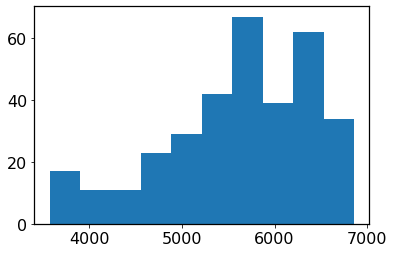

In [111]:
plt.hist(db_filtered['Teff1'])

### Define subsamples

In [68]:
# period limits
plim = db['koi_period'] < 100
kplim = kois_less['koi_period'] < 100
cksplim = cks['Per'] < 100

# filter the binaries
db_filtered = db[(db['Rppri'] < parameters.radius_limit) & (db['Rppri'] >=0.5) & plim].copy()
close = db_filtered['SepAU']<200
good = db_filtered['e_Rpkep']/db_filtered['Rpkep'] < parameters.max_radius_error

# filter the KOIs
kois_filtered = kois_less[(kois_less['koi_prad']<parameters.radius_limit)
                     & (kois_less['koi_prad'] >= 0.5) & kplim].copy()
kois_good = (kois_less['koi_prad_err1'] - kois_less['koi_prad_err2'])/2. < parameters.max_radius_error

# Filter CKS
cks_filtered = cks[(cks['Rp']<parameters.radius_limit) & (cks['Rp']>=0.5) & cksplim].copy()



In [112]:
for c in kois_filtered.columns:
    print(c)

kepid
kepoi_name
kepler_name
koi_disposition
koi_pdisposition
koi_period
koi_prad
koi_prad_err1
koi_prad_err2
koi_kepmag
KOI
source_id
parallax
parallax_over_error
kepler_gaia_ang_dist
phot_g_mean_mag
ruwe
bedell_cat


In [69]:
# separation values (as lists) for each star in binary sample
tmp = db_filtered[good & close].groupby('KOI')['SepAU'].agg('unique')
binary_separations = np.concatenate(tmp.to_numpy())

### Take a look at the samples

In [70]:
def calc_statistics(catalog, prad_col = 'Rp', star_col='KOI', MTPS=False):
    
    n_planets = float(len(catalog))
    print( "Number of planets: ", int(n_planets))
    print( "Number of stars: ", len(catalog[star_col].unique()))
    
    n_SEs = float(len(catalog.loc[catalog[prad_col]<parameters.radius_valley]))
    print("Frac super-Earths/n_planets: ", n_SEs/n_planets, "+-", np.sqrt(n_SEs)/n_planets)
    
    if MTPS:
        planet_counts = catalog.groupby(star_col).size().reset_index(name='n_planets')
        stps = len(planet_counts.loc[planet_counts['n_planets']==1])
        mtps = len(planet_counts.loc[planet_counts['n_planets']>1])
        print("Frac MTPS: ", mtps, stps, mtps/(stps+mtps), "+-", np.sqrt(mtps)/(stps+mtps))


# ----------------------------------------------
# Print all the samples and sub-samples
# ----------------------------------------------

        
print("BINARIES\n\n All")
calc_statistics(db_filtered[good], prad_col='Rppri')

print("\n Close (error good)")
calc_statistics(db_filtered[good & close], prad_col='Rppri')

print("\n Wide (error good)")
calc_statistics(db_filtered[good & ~close], prad_col='Rppri')

print("\n Close (any error)")
calc_statistics(db_filtered[close], prad_col='Rppri', MTPS=True)

print("\n Wide (any error)")
calc_statistics(db_filtered[~close], prad_col='Rppri', MTPS=True)


print("\n\nSINGLE KOIS")
calc_statistics(kois_filtered, prad_col='koi_prad', MTPS=True)
print("\nALL CKS")
calc_statistics(cks_filtered)

BINARIES

 All
Number of planets:  191
Number of stars:  138
Frac super-Earths/n_planets:  0.4293193717277487 +- 0.04741039339338962

 Close (error good)
Number of planets:  108
Number of stars:  79
Frac super-Earths/n_planets:  0.48148148148148145 +- 0.06676946806414795

 Wide (error good)
Number of planets:  83
Number of stars:  59
Frac super-Earths/n_planets:  0.3614457831325301 +- 0.06599066957893568

 Close (any error)
Number of planets:  159
Number of stars:  114
Frac super-Earths/n_planets:  0.5031446540880503 +- 0.0562532824528249
Frac MTPS:  30 84 0.2631578947368421 +- 0.04804583837764615

 Wide (any error)
Number of planets:  176
Number of stars:  135
Frac super-Earths/n_planets:  0.36363636363636365 +- 0.045454545454545456
Frac MTPS:  27 108 0.2 +- 0.03849001794597505


SINGLE KOIS
Number of planets:  2024
Number of stars:  1461
Frac super-Earths/n_planets:  0.26679841897233203 +- 0.011481175927492341
Frac MTPS:  379 1082 0.2594113620807666 +- 0.013325066621445439

ALL CKS
N

# Toy Model

next up I take the kois_less (kois with good params minus any that are binaries in kendall's list) and pretend every single star is actually a binary star with a separation drawn randomly from Kendall's sample's distribution of separations. Suppress the formation of > 2 Rearth planets using the suppression model and remake the histogram. Does it work?

In [99]:
def suppression_factor_simple(a_values):
    a_inner_true = 10  # AU (suppression 100%)
    a_outer_true = 200  # AU (suppression 0%)
    results = (np.log10(a_values) - np.log10(a_inner_true)) / (np.log10(a_outer_true) - np.log10(a_inner_true))
    return np.clip(results, a_min=0, a_max=1)

def suppression_simulation(planets_cat, separations=None, join_on='KOI', prad_col='koi_prad'):
    """
    Simulate the suppression of planet formation by stellar binaries. Return 
    the original (single-star host) planet population from ``planets_cat'',
    suppressed as if all the host stars are binaries with semi-major axes 
    drawn from the distribution defined by ``suppression_cat''.

    Parameters
    ----------
    planets_cat : pandas.DataFrame
        Table of single‑star host planets (must contain the radius column 
        given by ``prad_col`` and the join column given by ``join_on``).
    separations : np.array, sort of optional
        Array-like list of binary star separations from which to draw, in 
        units of astronomical units.
    join_on : str, optional
        Column name used to merge the two catalogs (default ``'KOI'``).
    prad_col : str, optional
        Column name for planet radius in ``planets_cat`` (default ``'Rp'``).

    Returns
    -------
    planet_radius : np.ndarray
        Radii of planets that survive the suppression process.
    planet_counts : pandas.DataFrame
        Number of surviving planets per KOI (columns ``'KOI'`` and 
        ``'n_planets'``).
    frac_super_earths :
        Fraction of surviving planets with radius < ``rad_valley``.
    frac_multiplanet : float
        Fraction of surviving KOIs that are multiplanet systems.
    """
    
    # ----------------------------------------------
    # Set-up
    # ----------------------------------------------

    # Number of UNIQUE stellar hosts
    d = {'KOI': planets_cat['KOI'].unique()}
    suppression_cat = pd.DataFrame(data=d)

    n_stars = len(suppression_cat)
    n_planets = len(planets_cat)

    # ----------------------------------------------
    # Assign a binary star to each planetary system
    # ----------------------------------------------   
    
    # Randomly draw a binary separation for each stellar host
    if separations is not None:
        random_separations = np.random.choice(separations, 
                                          size=n_stars, replace=True)
    else:
        raise()
        
    # Add the jitter to the sampled values
    #error_std = 0.1 * random_separations
    #random_error = np.random.normal(loc=0.0, scale=error_std)
    #random_separations = random_separations + random_error

    # Suppress planet formation (per STAR)
    suppression_cat['SepAU'] = random_separations
    suppression_cat['my_factor'] = suppression_factor_simple(random_separations)

    # Match STAR suppression to each PLANET
    # ``realization'' will hold the outcome of this simulation
    realization = planets_cat.merge(suppression_cat, on=join_on)
    realization['planet_exists'] = np.zeros(n_planets, dtype=bool) 

    # ----------------------------------------------
    # Suppress planets
    # ----------------------------------------------   

    # Condition 1: If Rp < 1.8, planet formation is not suppressed
    realization.loc[realization[prad_col] <= parameters.radius_valley, 'planet_exists'] = True

    # Condition 2: If Rp >= 1.8, planet formation probabilistically suppressed
    mask = (realization[prad_col] > parameters.radius_valley)
    random_vals = np.random.rand(n_planets)  # uniform random [0,1) to compare to my_factor
    realization.loc[mask, 'planet_exists'] = random_vals[mask] < realization['my_factor'][mask]
    
    print(realization[['KOI', 'kepid', 'koi_prad', 'SepAU', 'my_factor','planet_exists']])

    # ----------------------------------------------
    # Determine the properties of the suppressed population
    # ----------------------------------------------   
    
    # Only the planets that still exist
    obs = realization.loc[realization['planet_exists'] == 1].copy()
    planet_radius = obs[prad_col]

    n_super_earths_after = float(len(planet_radius[planet_radius < parameters.radius_valley]))
    n_planets_after = float(len(planet_radius))
    
    planet_counts = obs.groupby('KOI').size().reset_index(name='n_planets')    
    mtps = float(len(planet_counts.loc[planet_counts['n_planets']>1]))
    stps = float(len(planet_counts.loc[planet_counts['n_planets']==1]))
    
    
    return(planet_radius, planet_counts, 
           n_super_earths_after/n_planets_after, 
           mtps/(mtps+stps))

### Suppress the KOI sample

In [100]:
# define bins for recording plotting
histrange=[0.5,4]
nbins=13

bin_edges = np.linspace(histrange[0], histrange[1], nbins + 1)
bin_width = bin_edges[1] - bin_edges[0]
bin_center = bin_edges[:-1] + bin_width/2.


# run trials and save the results
ntrials = 10
koi_sim_hist = np.ones((ntrials,len(bin_center)))
koi_sim_npl = np.ones((ntrials,5))
frac_SE_arr = np.ones(ntrials)
mtps_arr = np.ones(ntrials)
for i in range(ntrials):
    prad_sim_tmp, sim_counts, frac_SE_arr[i], mtps_arr[i] = suppression_simulation(kois_filtered, 
                                                                              binary_separations,
                                                                              join_on='KOI', 
                                                                              prad_col='koi_prad')
    # histogram of planet radii
    hist, _ = np.histogram(prad_sim_tmp, 
            range=histrange, bins=nbins, density=True)
    koi_sim_hist[i] = hist
    

    # histogram of n_planets
    hist, _ = np.histogram(sim_counts['n_planets'], density=True, bins=[0.5,1.5,2.5,3.5,4.5,5.5])
    koi_sim_npl[i] = hist
    

low, koi_prad_sim, high = np.percentile(koi_sim_hist, q=(2.25,50,98.75), axis=0)
e_koi_prad_sim = (high-low)/2

koi_SE_frac = np.percentile(frac_SE_arr, q=(2.25,13.6,50,86.4, 98.75))
print(koi_SE_frac)

np.percentile(mtps_arr, q=(2.25,13.6,50,86.4, 98.75))

       KOI     kepid  koi_prad       SepAU  my_factor  planet_exists
0       41   6521045      2.26   16.193857   0.160911          False
1       41   6521045      1.30   16.193857   0.160911           True
2       41   6521045      1.55   16.193857   0.160911           True
3       46  10905239      1.18   61.959882   0.608833           True
4       49   9527334      2.74   57.260288   0.582503          False
...    ...       ...       ...         ...        ...            ...
2019  6233  10989274      2.25  183.357847   0.971000           True
2020  6863   7350067      0.95   60.335628   0.599966           True
2021  7378  10843431      3.29   23.710254   0.288184          False
2022  7892   8540376      2.71   90.599702   0.735668           True
2023  7913   8873450      2.03   57.260288   0.582503           True

[2024 rows x 6 columns]
       KOI     kepid  koi_prad       SepAU  my_factor  planet_exists
0       41   6521045      2.26   78.247166   0.686739           True
1       4

### Suppress the CKS sample

In [16]:
# Holder for the random separations for the STARS
d = {'KOI': cks_good['KOI'].unique()}
suppression_cat = pd.DataFrame(data=d)

cks_sim_hist = np.ones((ntrials,len(bin_center)))
frac_SE_arr = np.ones(ntrials)
for i in range(ntrials):
    prad_sim_tmp, frac_SE_arr[i] = planet_simulation(suppression_cat, cks_good, join_on='KOI', prad_col='Rp')
    hist, _ = np.histogram(prad_sim_tmp, 
            range=histrange, bins=nbins, density=True)
    cks_sim_hist[i] = hist
    
low, cks_prad_sim, high = np.percentile(cks_sim_hist, q=(2.25,50,98.75), axis=0)
e_cks_prad_sim = (high-low)/2

cks_SE_frac = np.percentile(frac_SE_arr, q=(2.25,13.6, 50,86.4,98.75))

print(cks_SE_frac)

NameError: name 'cks_good' is not defined

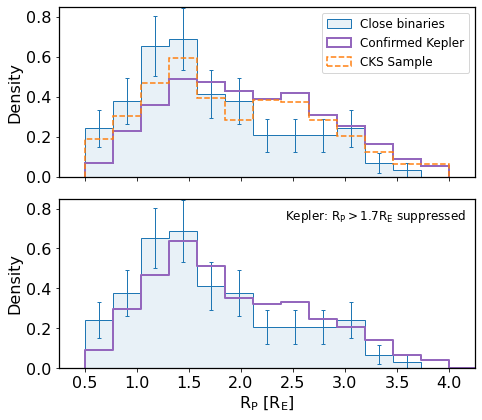

In [101]:
fig, axes = plt.subplots(2, 1, figsize=(7,6), sharex=True, sharey=True)

# planets with good radii in binary systems with rho<100 au and planet period < 100 days
y, _, _ = axes[0].hist(db_filtered['Rppri'][good & close], 
             range=histrange, bins=nbins, density=True, 
         histtype='stepfilled', edgecolor='#1f77b4', facecolor='#e8f1f7',
        label='Close binaries')
n, _ = np.histogram(db['Rppri'][good & close & plim], 
             range=histrange, bins=nbins)

axes[0].errorbar(bin_center, y, np.sqrt(n)/np.sum(n)/bin_width, ls='None', lw=1, capsize=2, c='C0')


# compared to the kois that are at least not definite binaries with good radii and per<100 days
axes[0].hist(kois_filtered['koi_prad'], 
             range=histrange, bins=nbins, density=True, 
             histtype='step', lw=2, color='C4',
        label='Confirmed Kepler')

# compared to the cks
axes[0].hist(cks_filtered['Rp'], 
             range=histrange, bins=nbins, density=True, 
             histtype='step',lw=1.5, linestyle='--', color='C1',
        label='CKS Sample')

axes[0].set_ylabel('Density')
axes[0].legend()

# planets with good radii in binary systems with rho<100 au and planet period < 100 days
axes[1].hist(db_filtered['Rppri'][good & close], 
             range=histrange, bins=nbins, density=True, 
             histtype='stepfilled',  edgecolor='#1f77b4', facecolor='#e8f1f7')
axes[1].errorbar(bin_center, y, np.sqrt(n)/np.sum(n)/bin_width, ls='None', lw=1, capsize=2, c='C0')


x = np.concatenate((bin_edges, [bin_edges[-1]+bin_width]))
y = np.concatenate(([0], koi_prad_sim, [0]))
plt.step(x, y, c='C4', lw=2)
#y = np.concatenate(([0], cks_prad_sim, [0]))
#plt.errorbar(bin_center-0.02, koi_prad_sim, e_koi_prad_sim, ls='None', lw=2, capsize=3, c='C4')
#plt.step(x, y, linestyle='--', c='C1', lw=1.5)
#plt.errorbar(bin_center+0.025, cks_prad_sim, e_cks_prad_sim, ls='None', lw=1.5, capsize=2, c='C1')

axes[1].text(0.98, 0.95, 'Kepler: $R_P>1.7 R_E$ suppressed ',
     horizontalalignment='right',
     verticalalignment='top',
     transform = axes[1].transAxes)

plt.xlim(0.25, 4.25)
plt.ylim(0,0.85)
plt.xlabel('$R_P$ [$R_E$]')
plt.ylabel('Density')
plt.tight_layout()
plt.savefig('suppression_sim-1p7Re.png')

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(7,6), sharex=True, sharey=True)

kois_subsample = kois_good[(kois_good['koi_prad_err1']/kois_good['koi_prad'] < 0.05) & \
    (kois_good['koi_prad_err2']/kois_good['koi_prad'] < 0.05)].copy()

# compared to the kois that are at least not definite binaries with good radii and per<100 days
axes[0].hist(kois_subsample['koi_prad'], 
             range=histrange, bins=nbins, density=True, 
             histtype='step', lw=2, color='C4',
        label=r'KOIs ($\sigma_{R_P}<5\%$)')

axes[0].hist(kois_subsample['koi_prad'][kois_subsample['multiplanet_system?']], 
             range=histrange, bins=nbins, density=True, 
             histtype='step', ls = ':', lw=2, color='C4',
        label='Multis')

axes[0].set_ylabel('Density')
axes[0].legend(loc='upper right')


kois_subsample = kois_good[(kois_good['koi_prad_err1']/kois_good['koi_prad'] < 0.1) & \
    (kois_good['koi_prad_err2']/kois_good['koi_prad'] < 0.1) & \
    (kois_good['koi_period'] < 50) & (kois_good['koi_period'] > 10)].copy()


# compared to the kois that are at least not definite binaries with good radii and per<100 days
axes[1].hist(kois_subsample['koi_prad'], 
             range=histrange, bins=nbins, density=True, 
             histtype='step', lw=2, color='C4',
        label='KOIs ($10<P_P<50$)')

axes[1].hist(kois_subsample['koi_prad'][kois_subsample['multiplanet_system?']], 
             range=histrange, bins=nbins, density=True, 
             histtype='step', ls = ':', lw=2, color='C4',
        label='Multis')

axes[1].set_ylabel('Density')
axes[1].legend(loc='upper left')

plt.savefig('multi_subsets.pdf')

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(7,6), sharex=True, sharey=True)

axes[0].hist(db['koi_prad'][db['multiplanet_system?'] & good & close], 
             range=histrange, bins=nbins, density=True, 
             histtype='step', lw=2, color='C4',
        label=r'MTPS, close')

axes[0].hist(db['koi_prad'][~db['multiplanet_system?'] & good & close], 
             range=histrange, bins=nbins, density=True, 
             histtype='step', lw=2,  ls = ':', color='C4',
        label=r'STPS, close')

axes[1].hist(db['koi_prad'][db['multiplanet_system?'] & good & ~close], 
             range=histrange, bins=nbins, density=True, 
             histtype='step', lw=2, color='C4',
        label='MTPS, distant')

axes[1].hist(db['koi_prad'][~db['multiplanet_system?'] & good & ~close], 
             range=histrange, bins=nbins, density=True, 
             histtype='step', ls = ':', lw=2, color='C4',
        label='STPS, distant')

for ax in axes:
    ax.set_ylabel('Density')
    ax.legend(loc='upper right')
    
plt.xlabel('$R_P$ [$R_E$]')

In [ ]:
stps = len(db['KOI'][~db['multiplanet_system?'] & good & ~close].unique())
mtps = len(db['KOI'][db['multiplanet_system?'] & good & ~close].unique())
print("Wide binaries MtPS: ", mtps, stps, mtps/(stps+mtps), "+-", np.sqrt(mtps)/(stps+mtps))

In [ ]:
stps = len(db['KOI'][~db['multiplanet_system?'] & good & close].unique())
mtps = len(db['KOI'][db['multiplanet_system?'] & good & close].unique())
print("Close binaries MTPS: ", mtps, stps, mtps/(stps+mtps), "+-", np.sqrt(mtps)/(stps+mtps))

In [ ]:
stps = len(kois_good['KOI'][~kois_good['multiplanet_system?']].unique())
mtps = len(kois_good['KOI'][kois_good['multiplanet_system?']].unique())
print("KOI MTPS: ", mtps/(stps+mtps), "+-", np.sqrt(mtps)/(stps+mtps))

In [ ]:
plt.hist(kois_good['koi_prad'][~kois_good['multiplanet_system?']], 
             density=True, 
             histtype='step', ls = '-', lw=2, color='C4',
        label='STPS, distant')
plt.hist(kois_good['koi_prad'][kois_good['multiplanet_system?']], 
             density=True, 
             histtype='step', ls = ':', lw=2, color='C4',
        label='STPS, distant')

In [ ]:
x = np.array([1,2,3,4,5])

close_planet_counts = db[good & close].groupby('KOI').size().reset_index(name='n_planets')
koi_planet_counts = kois_good.groupby('KOI').size().reset_index(name='n_planets')

fig, axes = plt.subplots(1, 1, figsize=(7,5), sharex=True, sharey=True)

y, _ = np.histogram(close_planet_counts['n_planets'], density=True, bins=[0.5,1.5,2.5,3.5,4.5,5.5])
plt.bar(x, y, edgecolor='#1f77b4', facecolor='#e8f1f7', width=0.9, lw=1.5, label='Close binaries')

y, _ = np.histogram(koi_planet_counts['n_planets'], density=True, bins=[0.5,1.5,2.5,3.5,4.5,5.5])     
plt.bar(x-0.2, y, edgecolor='C4', facecolor='None', hatch='/', width=0.3, lw=1.5, label='Kepler (confirmed)')

low, npl_sim, high = np.percentile(koi_sim_npl, q=(2.25,50,98.75), axis=0)
e_npl_sim = (high-low)/2

plt.bar(x+0.2, npl_sim, edgecolor='C4', facecolor='C4', width=0.3, lw=1.5, label='Kepler (suppressed)')
#plt.errorbar(, koi_prad_sim, e_koi_prad_sim, ls='None', lw=2, capsize=3, c='C4')

plt.legend()
plt.ylabel('Density')
plt.xlabel('Number of planets per star')
plt.tight_layout()
plt.savefig('nplanets2.png')

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(7,5), sharex=True, sharey=True)

y, _ = np.histogram(close_planet_counts['n_planets'], density=True, bins=[0.5,1.5,2.5,3.5,4.5,5.5])
plt.bar(x, y, edgecolor='#1f77b4', facecolor='#e8f1f7', width=0.9, linewidth=1.5, label='Close binaries')

wide_planet_counts = db[good & ~close].groupby('KOI').size().reset_index(name='n_planets')
y, _ = np.histogram(wide_planet_counts['n_planets'], density=True, bins=[0.5,1.5,2.5,3.5,4.5,5.5])
plt.bar(x, y, edgecolor='gray', facecolor='None', hatch="\\", width=0.4, linewidth=1.5, label='Wide binaries')

plt.legend()
plt.ylabel('Density')
plt.xlabel('Number of planets per star')
plt.tight_layout()
plt.savefig('nplanets1.png')